In [2]:
from os.path import join,expanduser
import sys
import cmocean as cmo
# identify user's home directory
user_home_dir = expanduser('~')
# import the ECCOv4 py library 
sys.path.insert(0,join(user_home_dir,'ECCOv4-py'))
import ecco_v4_py as ecco
import botocore
import boto3
from boto3.session import Session
import cmocean
from collections import Counter
from dask.distributed import Client
import datetime
import fsspec
from gc import get_referents
import json
from matplotlib import colors as mcolors
from matplotlib.cm import ScalarMappable
import numpy as np
from pathlib import Path
from pprint import pprint
import requests
import s3fs
import sys
from sys import getsizeof
import time as time
from types import ModuleType, FunctionType
import xarray as xr
import matplotlib.pyplot as plt
import zarr
import pandas as pd


In [3]:
#1.Open the ECCO grid files
grid_dir  = Path('/home/jovyan/efs_ecco/ECCO/V4/r5/netcdf/native/geometry/')
ds_grid   = xr.open_dataset(grid_dir / 'GRID_GEOMETRY_ECCO_V4r5_native_llc0090.nc')

## Open the monthly temperature-salinity files
directory = Path('/home/jovyan/efs_ecco/ECCO/V4/r5/netcdf/native/mon_mean/OCEAN_TEMPERATURE_SALINITY')
# list sub-directories (one per dataset) 1992 - 2019
ecco_v4r5_mon_mean_native_dataset_paths = np.sort(list(directory.glob('*')))

## Organise temperature data into 12 (month) folders, each of them containing OHC throughout 1992-2019:
T         = [[] for _ in range(12)]
for i, file_path in enumerate(ecco_v4r5_mon_mean_native_dataset_paths):##loops throughout the 336 monthly files 1992-2019
    ds        = xr.open_dataset(file_path)
    month_idx = int(ds.time.dt.month.item()) - 1 # Extract month (1–12), convert to index (0–11)
    temp      = ds.THETA
    T[month_idx].append(temp)
depth_names   = T[0][0].Z.values ## extract the depths from a random temperature file
##set some constants
rho       = 1025  # kg/m³
cp        = 3985   # J/(kg·°C)
deep      = 6;shallow = 0 ##choose indices of the lowest and upper depth of the water column to be examined
##construct the thickness of
upper     = ds_grid.Zu;bottom = ds_grid.Zl
dz        = bottom - upper;
dz_1d     = xr.DataArray([dz.isel(k_l=i, k_u=i).values for i in range(dz.sizes['k_l'])], dims=['k'])
dz_layer  = dz_1d.isel(k=slice(shallow, deep))  # select the dz values for the vertical slice


In [4]:
##2. Calculate the monthly OHC for a given tile in the SO
tile        = 0
OHC_monthly = [[] for _ in range(12)]  # Store one 3D field per month-year
for month in range(12):
    for temp in T[month]:  # each `temp` is one DataArray (tile, k, j, i)
        temp_layer        = temp[0].isel(k=slice(shallow, deep))  # select k=0 to 6
        dz_layer_reshaped = dz_layer.broadcast_like(temp_layer)
        ohc               = (temp_layer * dz_layer_reshaped).sum(dim="k")  # °C·m
        ohc               = ohc * rho * cp  # Convert to J/m²
        OHC_monthly[month].append(ohc)
# -- -- -- -- 2D Monthly OHC anomalies -- -- -- -- 
#a list of 12 xarray DataArrays, one per month, each with dimensions (year, tile, j, i)
OHC_monthly_stacked = [xr.concat(month_data, dim="year") for month_data in OHC_monthly]
#a list of 12 DataArrays, one per month, each with dimensions (tile, j, i)
OHC_climatology     = [monthly.mean(dim="year") for monthly in OHC_monthly_stacked]
OHC_anomalies       = [monthly - climatology for monthly, climatology in zip(OHC_monthly_stacked, OHC_climatology)]
## -- -- -- -- MONTHLY OHC Timeseries -- -- -- -- 
TMSROHC        = [] ## Store timeseries
for i, file_path in enumerate(ecco_v4r5_mon_mean_native_dataset_paths):##This loops through
    ds         = xr.open_dataset(file_path);
    temp       = ds.THETA
    temp_layer = temp[0].isel(k=slice(shallow, deep))  # select k=0 to 6
    dz_layer_reshaped = dz_layer.broadcast_like(temp_layer)
    ohc        = (temp_layer * dz_layer_reshaped).sum(dim="k")  # °C·m
    ohc        = ohc * rho * cp  # Convert to J/m²
    ohc_fin    = ohc[tile,:,:].mean(dim=["j","i"],skipna=True)
    TMSROHC.append(ohc_fin)
## --  -- -- -- Monthly Anomalous OHC Timeseries  -- -- -- -- 
TMSROHC_da          = xr.concat(TMSROHC, dim='time')
start_date          = pd.to_datetime(str(TMSROHC_da.time.values[0]))
dates               = pd.date_range(start = start_date, periods=TMSROHC_da.sizes['time'], freq='MS')
ts_pd               = pd.Series(TMSROHC_da.values, index=dates, name='ts_x')
monthly_clim        = ts_pd.groupby(ts_pd.index.month).mean()# 3. Now group by calendar month and compute the climatology:
# 4. Tile the 12-month climatology to full length:
n_months            = len(ts_pd)
n_repeats           = n_months // 12
clim_full           = np.tile(monthly_clim.values, n_repeats)
# 5. Re-wrap into a Series aligned with your dates:
clim_full_series    = pd.Series(clim_full, index=ts_pd.index, name='Climatology')
anomalies           = ts_pd - clim_full_series


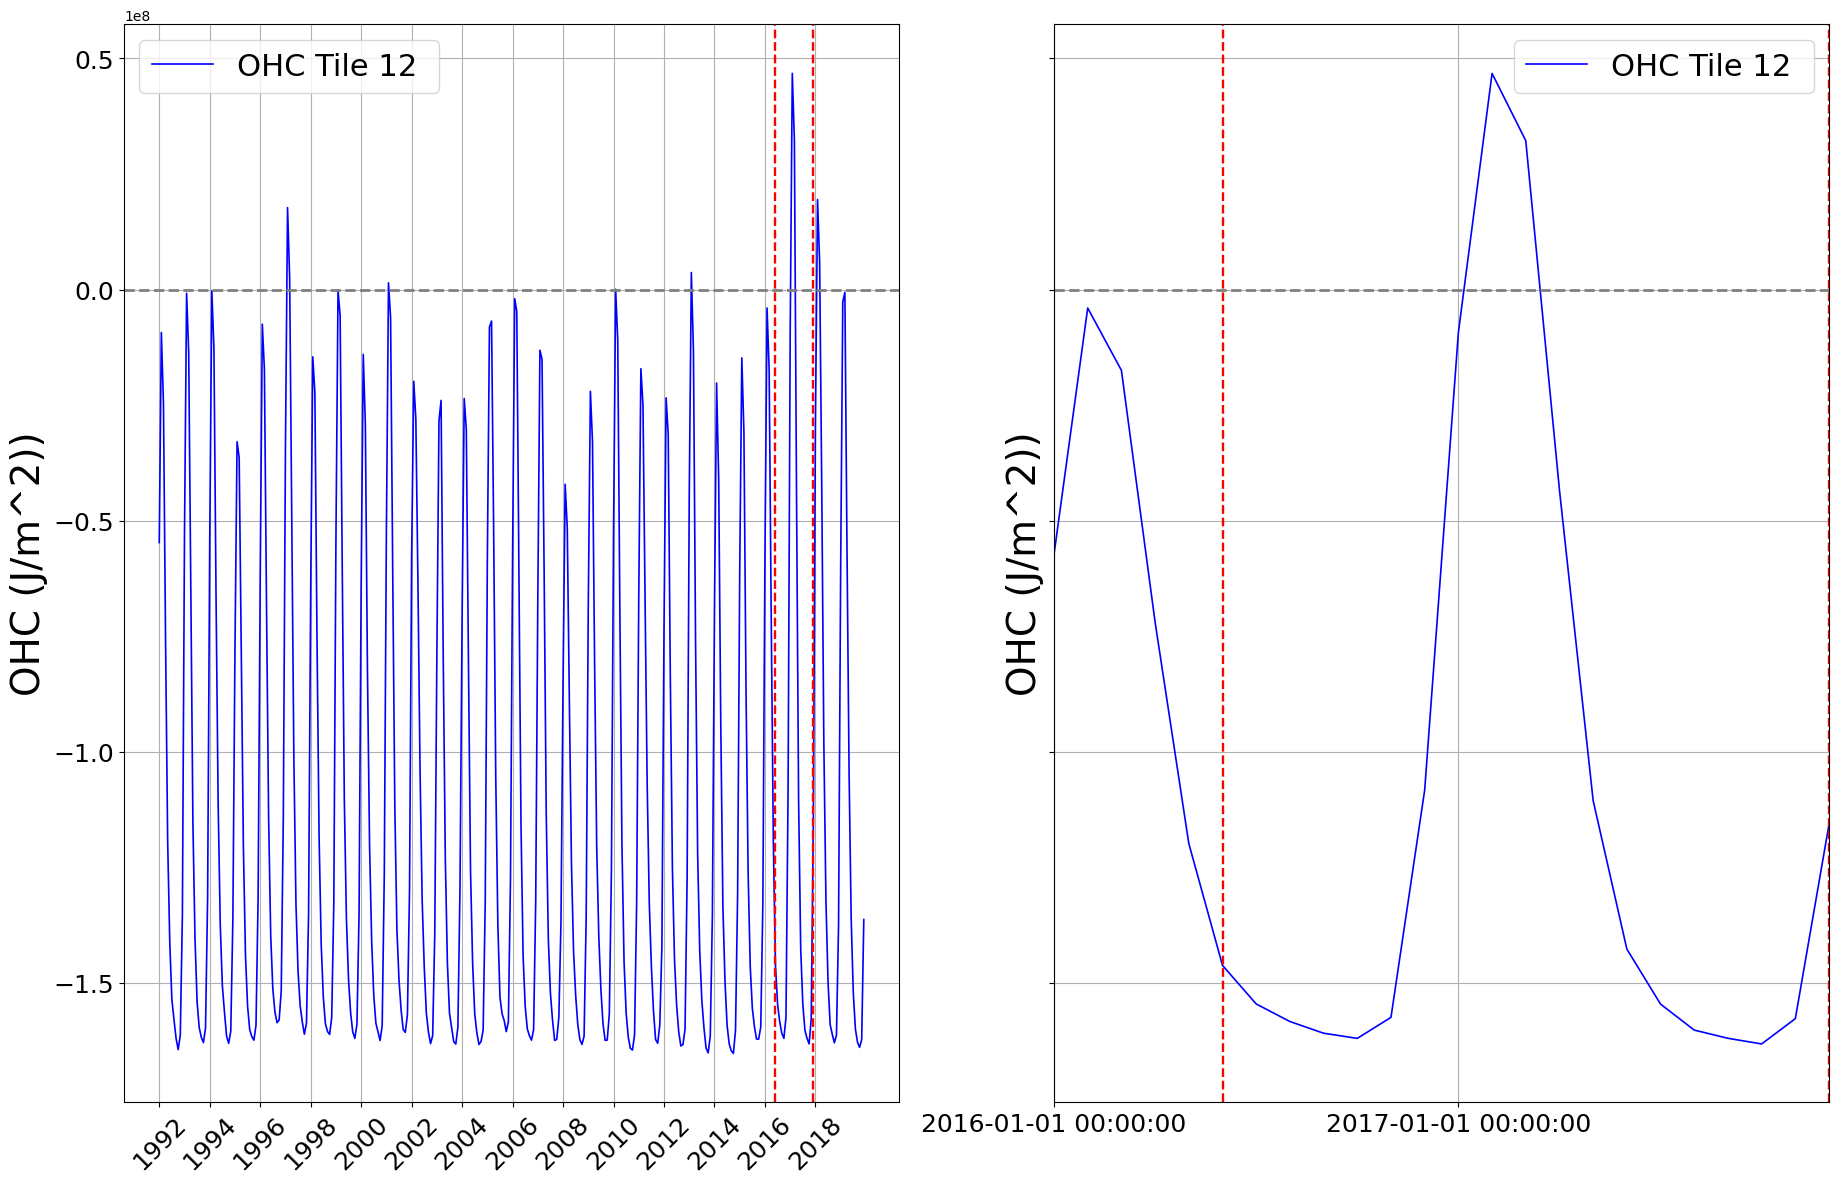

In [15]:
#3.Monhly OHC Spatially-averaged Timeseries over specific Tiles ==== 
montitles   = ["Jan","Feb","Mar","Apr","May","Jun","Jul","Aug","Sep","Oct","Nov","Dec"]
mon         = 1
tile        = 12 #Specify the tile from ECCO butterfly structure
label       = [f"OHC Tile {tile} "]
ystart      = 1992; yfin =2019
nyears      = (yfin - ystart)+1
nmonths     = nyears * 12
year_labels = [str(year) for year in range(ystart, yfin)]
year_ticks  = list(range(0, nmonths, 12))  # one tick every 12 months
# compute zoom plot indices for 2 years
start_ev    = 2016; fin_ev = 2017 ##starting and ending year of the zoom plot
starty1     = (start_ev - ystart) * 12        # = 24*12 = 288  → Jan 2016
finy2       = (fin_ev - ystart) * 12 + 11   # = 25*12+11 = 311 → Dec 2017
zoom_idx    = list(range(starty1, finy2 + 1))  # 288…311

##- - - -  Plot the absolute OHC Timeseries - - - - -
nrow        = 1;ncol=2
fig, axs    = plt.subplots(nrow,ncol,figsize=(22,14),sharey=True);axis= fig.axes
### 1st plot of OHC throughout 1992-2019
axis[0].plot(range(nmonths), TMSROHC, label=label, color="blue", linewidth=1.2)
axis[0].set_xticks(year_ticks[::2])
axis[0].set_xticklabels(year_labels[::2], fontsize=20,rotation=45)
### 2nd plot of OHC between 2016-2017
axis[1].plot(zoom_idx, TMSROHC[zoom_idx[0]:zoom_idx[-1]+1],label=label, color="blue",  linewidth=1.2)
axis[1].set_xlim(zoom_idx[0], zoom_idx[-1])# label only the two years to zoom in on the timeseries
axis[1].set_xticks(np.arange(zoom_idx[0], zoom_idx[-1],12))
axis[1].set_xticklabels([f'{dates[zoom_idx[0]]}',f'{dates[zoom_idx[0]+12]}'], fontsize=20)

### Locate the timestep that I want to plot the vertical  lines of starting and ending of the period 
dates = pd.date_range(start='1992-01-01', periods=336, freq='MS')  # Monthly Start dates
timestep1 = np.where((dates.year == 2016) & (dates.month == 6))[0][0]  # June 2002
timestep2 = np.where((dates.year == 2017) & (dates.month == 12))[0][0]  # Dec 2003
for i in range(0,2):
 axis[i].axhline(0, color='gray', linewidth=2, linestyle='--')
 axis[i].tick_params(axis='both', labelsize=18)
 axis[i].set_ylabel('OHC (J/m^2))', fontsize=28); axis[i].legend(loc="best",fontsize=22)
 axis[i].grid(True)
 axis[i].axvline(x=timestep1, color='red', linestyle='--', linewidth=1.7, label='Dec 2016')
 axis[i].axvline(x=timestep2, color='red', linestyle='--', linewidth=1.7, label='Feb 2017')
plt.savefig(f'/home/jovyan/efs_ecco/sdarma/FIGURES/FINAL_FIG/OHC_TMSR_TILE{tile}_{montitles[mon]}_{fin_ev}_{depth_names[shallow]}m_{depth_names[deep]}m.png')



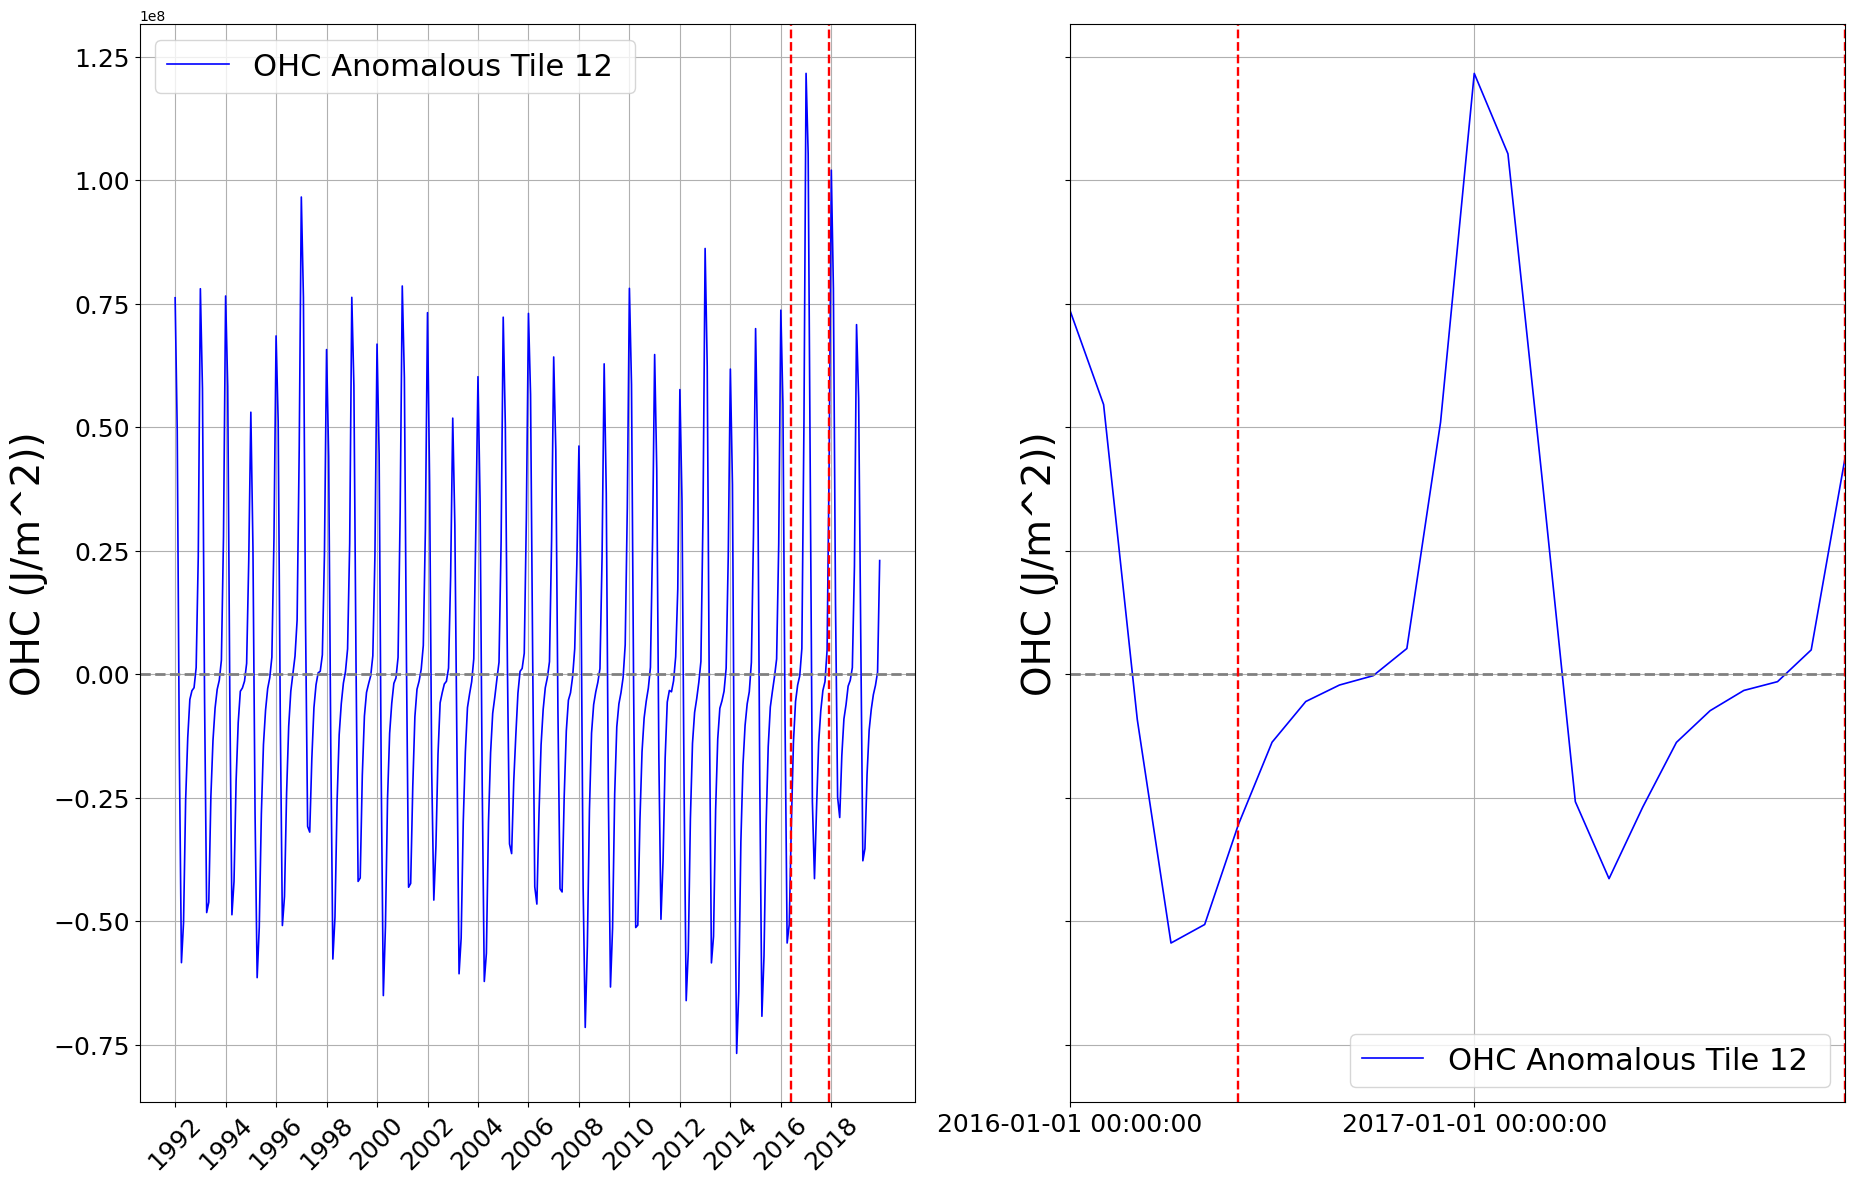

In [16]:
##4. PLOT THE MONTHLY ANOMALOUS OHC TIMESERIES =========
label       = [f"OHC Anomalous Tile {tile} "]
nyears      = (yfin - ystart)+1
nmonths     = nyears * 12
year_labels = [str(year) for year in range(ystart, yfin)]
year_ticks  = list(range(0, nmonths, 12))  # one tick every 12 months
# compute zoom plot indices for 2 years
start_ev    = 2016; fin_ev = 2017 ##starting and ending year of the zoom plot
starty1     = (start_ev - ystart) * 12        # = 24*12 = 288  → Jan 2016
finy2       = (fin_ev - ystart) * 12 + 11   # = 25*12+11 = 311 → Dec 2017
zoom_idx    = list(range(starty1, finy2 + 1))  # 288…311
nrow        = 1;ncol=2
### Make the plot
fig, axs    = plt.subplots(nrow,ncol,figsize=(22,14),sharey=True);axis= fig.axes
### 1st plot of OHC throughout 1992-2019
axis[0].plot(range(nmonths), anomalies, label=label, color="blue", linewidth=1.2)
axis[0].set_xticks(year_ticks[::2])
axis[0].set_xticklabels(year_labels[::2], fontsize=20,rotation=45)
### 2nd plot of OHC between 2016-2017
axis[1].plot(zoom_idx, anomalies[zoom_idx[0]:zoom_idx[-1]+1],label=label, color="blue",  linewidth=1.2)
axis[1].set_xlim(zoom_idx[0], zoom_idx[-1])# label only the two years to zoom in on the timeseries
axis[1].set_xticks(np.arange(zoom_idx[0], zoom_idx[-1],12))
axis[1].set_xticklabels([f'{dates[zoom_idx[0]]}',f'{dates[zoom_idx[0]+12]}'], fontsize=20)
### Locate the timestep that I want to plot the vertical  lines of starting and ending of the period 
dates = pd.date_range(start='1992-01-01', periods=336, freq='MS')  # Monthly Start dates
timestep1 = np.where((dates.year == 2016) & (dates.month == 6))[0][0]  # June 2002
timestep2 = np.where((dates.year == 2017) & (dates.month == 12))[0][0]  # Dec 2003
for i in range(0,2):
 axis[i].axhline(0, color='gray', linewidth=2, linestyle='--')
 axis[i].tick_params(axis='both', labelsize=18)
 axis[i].set_ylabel('OHC (J/m^2))', fontsize=28); axis[i].legend(loc="best",fontsize=22)
 axis[i].grid(True)
 axis[i].axvline(x=timestep1, color='red', linestyle='--', linewidth=1.7, label='Dec 2016')
 axis[i].axvline(x=timestep2, color='red', linestyle='--', linewidth=1.7, label='Feb 2017')
plt.savefig(f'/home/jovyan/efs_ecco/sdarma/FIGURES/FINAL_FIG/OHC_TMSR_ANOMALIES_TILE{tile}_{montitles[mon]}_{fin_ev}_{depth_names[shallow]}m_{depth_names[deep]}m.png')
